# The Battle of Neighborhoods
## Capstone Project

##### About
In this project we will be **Clustering** **_New Delhi_** and later use it to predict simillarity with **_Bangalore_** 

Let's import necessary libraries first

In [1]:
import pandas as pd
import numpy as np
import csv # for saving table as a csv file

Now let's get the data about New Delhi. We are using Wikipedia to get the neighbourhood names and places of New Delhi

In [2]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_districts_of_Delhi')

We know our required details are stored in 1st table of our variable table so let's assign it to new variable called delhi

In [3]:
delhi = tables[0]

In [4]:
print(f'The Shape of delhi is {delhi.shape}')
delhi.head()

The Shape of delhi is (12, 6)


,0,1,2,3,4,5
0,Sl.No.,District,Headquarter,Sub divisions (Tehsils),NaN,NaN
1,1,New Delhi,Connaught Place,Chanakyapuri,Delhi Cantonment,Vasant Vihar
2,2,North Delhi,Narela,Model Town[3],Narela,Alipur
3,3,North West Delhi,Kanjhawala,Rohini,Kanjhawala,Saraswati Vihar
4,4,West Delhi,Rajouri Garden,Patel Nagar,Punjabi Bagh,Rajouri Garden


Now let's process the above table to extract names out of it and save them as a csv file so that we can use it later

In [5]:
csv_file = open('New_Delhi_Individual.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['District','Neighbourhood'])
for i in range(1,delhi.shape[0]):
    dist = delhi.iloc[i,1]
    nhood = delhi.iloc[i,2]
    csv_writer.writerow([dist,nhood])
    nhood = delhi.iloc[i,3]
    csv_writer.writerow([dist,nhood])
    nhood = delhi.iloc[i,4]
    csv_writer.writerow([dist,nhood])
    nhood = delhi.iloc[i,5]
    csv_writer.writerow([dist,nhood])
    
csv_file.close()

In [6]:
New_Delhi_Individual = pd.read_csv('New_Delhi_Individual.csv')
New_Delhi_Individual.head()

,District,Neighbourhood
0,New Delhi,Connaught Place
1,New Delhi,Chanakyapuri
2,New Delhi,Delhi Cantonment
3,New Delhi,Vasant Vihar
4,North Delhi,Narela


As we require latitute and longitude to get venues from foresquare we will asign a unique Key to them so that we can merge our this dataframe with the one containing the lat and long (which we will be making next)

In [7]:
unique_no = np.arange(New_Delhi_Individual.shape[0])
idx = 0  
New_Delhi_Individual.insert(loc=idx, column='Key', value=unique_no)
New_Delhi_Individual.head()

,Key,District,Neighbourhood
0,0,New Delhi,Connaught Place
1,1,New Delhi,Chanakyapuri
2,2,New Delhi,Delhi Cantonment
3,3,New Delhi,Vasant Vihar
4,4,North Delhi,Narela


Now we need the coordinates to query API so we will utilize geopy to get the respective coordinates and save them in a csv file so that we can use it later and merge it with New_Delhi_Individual

In [11]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

csv_file = open('Delhi_Individual_Geo.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Key','latitude','longitude'])

for i in range(New_Delhi_Individual.shape[0]):
    my_address = f'{New_Delhi_Individual.iloc[i,2]}, New Delhi'
    geolocator = Nominatim()
    try:
        location = geolocator.geocode(my_address)
        lat = location.latitude
        lon = location.longitude
        key = New_Delhi_Individual.iloc[i,0]
        csv_writer.writerow([key,lat,lon])
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s"%(my_address))
    
csv_file.close() 

C:\Users\Ashish Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  # Remove the CWD from sys.path while we load stuff.


AttributeError: 'NoneType' object has no attribute 'latitude'

Because of geopy's terms and few other resons it returned coordinates for some places and failed for others therefore I manually added the remaining coordinates to the file so let's import it and merge with New_Delhi_Individual

In [13]:
Delhi_Individual_Geo = pd.read_csv('Delhi_Individual_Geo.csv')
Delhi_Individual_Geo.head()

,Key,latitude,longitude
0,0,28.6315,77.2167
1,1,28.5939,77.1887
2,2,28.5961,77.1587
3,3,28.5603,77.1617
4,4,28.8540,77.0918


Now Let's merge them together

In [14]:
New_Delhi_Complete = New_Delhi_Individual.merge(Delhi_Individual_Geo,how='left',on='Key')

In [5]:
New_Delhi_Complete.head()

,Key,District,Neighbourhood,latitude,longitude
0,0,New Delhi,Connaught Place,28.6315,77.2167
1,1,New Delhi,Chanakyapuri,28.5939,77.1887
2,2,New Delhi,Delhi Cantonment,28.5961,77.1587
3,3,New Delhi,Vasant Vihar,28.5603,77.1617
4,4,North Delhi,Narela,28.8540,77.0918


Let's visiualise this with the help of folium

In [6]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from IPython.display import HTML, display

In [7]:
latitude = 28.644800
longitude = 77.216721
# create map of New Delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat,long,neighbourhood in zip(New_Delhi_Complete['latitude'],New_Delhi_Complete['longitude'],New_Delhi_Complete['Neighbourhood']):
    label = f'{neighbourhood}'
    label = folium.Popup(label)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='yellow',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7).add_to(map_delhi)
    
map_delhi

Now, we are ready to start utilizing the Foursquare API to explore the neighborhoods and segment them

Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = 'STFUCS3KWVLQWKTI4MZYIQQCG4JVWYSND4BZXINYYYNMYFOU' 
CLIENT_SECRET = 'JCTRZJGKUUCLHN0A0AYVB1HWT3CQ3WNNPQ13WRZ31GNVAACI' 
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: STFUCS3KWVLQWKTI4MZYIQQCG4JVWYSND4BZXINYYYNMYFOU
CLIENT_SECRET:JCTRZJGKUUCLHN0A0AYVB1HWT3CQ3WNNPQ13WRZ31GNVAACI


As we get JSON as a response from Foresquare so let's import necessary library to handle it

In [92]:
import requests # library to handle requests
from pandas.io.json import json_normalize

Let's build a function which will help to parse the json and store the respective values in the dataframe

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
complete_delhi_venues = getNearbyVenues(names=New_Delhi_Complete['Neighbourhood'],
                                   latitudes=New_Delhi_Complete['latitude'],
                                   longitudes=New_Delhi_Complete['longitude']
                                  )

Connaught Place
Chanakyapuri
Delhi Cantonment
Vasant Vihar
Narela
Model Town
Alipur
Rohini
Saraswati Vihar
Rajouri Garden
Patel Nagar
Punjabi Bagh
Dwarka
Najafgarh
Kapashera
Saket
Hauz Khas
Mehrauli
Defence Colony
Kalkaji
Sarita Vihar
Daryaganj
Kotwali
Civil Lines
Karol Bagh
Seelampur
Yamuna Vihar
Shahdara
Seemapuri
Vivek Vihar
Preet Vihar
Mayur Vihar
Adarsh Nagar
Ashok Vihar
Azadpur
Bawana
Begum Pur
Keshav Puram
Kingsway Camp
Pitam Pura
Rani Bagh
Chandni Chowk
Bara Hindu Rao
Chawri Bazaar
Kashmiri Gate
Paharganj
Pratap Nagar
Sadar Bazaar
Sarai Kale Khan
Shakti Nagar
Tees Hazari
Babarpur
Dilshad Garden
Mandoli
Shastri Park
Jhandewalan
Barakhamba Road
Gautampuri
Laxmibai Nagar
Pragati Maidan
INA Colony
Brij Puri
Geeta Colony
Krishna Nagar
Laxmi Nagar
Pandav Nagar
Patparganj
Anand Vihar
Shastri Nagar
Chhattarpur
Chittaranjan Park
Govindpuri
Greater Kailash
Green Park
Gulmohar Park
Lajpat Nagar
Lodi Colony
Maharani Bagh
Malviya Nagar
Netaji Nagar
Nizamuddin West
Okhla
Siri Fort
Dhaula Kua

Let's check the size of the resulting dataframe

In [25]:
print(complete_delhi_venues.shape)
complete_delhi_venues.head()

(654, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Connaught Place,28.6315,77.2167,HOTEL SARAVANA BHAVAN,28.632319,77.216445,South Indian Restaurant
1,Connaught Place,28.6315,77.2167,Starbucks Coffee,28.632011,77.217731,Coffee Shop
2,Connaught Place,28.6315,77.2167,Wenger's,28.633412,77.218292,Bakery
3,Connaught Place,28.6315,77.2167,Pind Balluchi,28.630318,77.217600,North Indian Restaurant
4,Connaught Place,28.6315,77.2167,Fabindia,28.632012,77.217729,Clothing Store


Let's check how many venues were returned for each neighborhood

In [26]:
complete_delhi_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adarsh Nagar,3,3,3,3,3,3
Alipur,1,1,1,1,1,1
Anand Vihar,7,7,7,7,7,7
Ashok Vihar,4,4,4,4,4,4
Azadpur,5,5,5,5,5,5
Babarpur,1,1,1,1,1,1
Bara Hindu Rao,3,3,3,3,3,3
Barakhamba Road,23,23,23,23,23,23
Bawana,1,1,1,1,1,1


Let's analyse each neighbourhood

In [27]:
# one hot encoding
delhi_onehot = pd.get_dummies(complete_delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhood'] = complete_delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [delhi_onehot.columns[-1]] + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]

delhi_onehot.head()

,Women's Store,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Sporting Goods Shop,Tea Room,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Weight Loss Center
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size

In [28]:
delhi_onehot.shape

(654, 132)

Now, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()
delhi_grouped

,Neighborhood,Women's Store,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Sporting Goods Shop,Tea Room,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Weight Loss Center
0,Adarsh Nagar,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.333333,0.000000,0.0
1,Alipur,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,Anand Vihar,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,Ashok Vihar,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,Azadpur,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0
5,Babarpur,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0
6,Bara Hindu Rao,0.000000,0.0,0.666667,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.333333,0.000000,0.0
7,Barakhamba Road,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.043478,...,0.000000,0.043478,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0
8,Bawana,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0
9,Begum Pur,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0


Let's confirm the new size

In [9]:
delhi_grouped.shape

(89, 132)

Let's print each neighborhood along with the top 5 most common venues

In [70]:
num_top_venues = 5

for hood in delhi_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = delhi_grouped[delhi_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adarsh Nagar----
                venue  freq
0       Train Station  0.33
1      Cosmetics Shop  0.33
2  Light Rail Station  0.33
3       Women's Store  0.00
4           Nightclub  0.00


----Alipur----
                             venue  freq
0                              ATM   1.0
1  Molecular Gastronomy Restaurant   0.0
2                             Park   0.0
3    Paper / Office Supplies Store   0.0
4                      Outlet Mall   0.0


----Anand Vihar----
               venue  freq
0  Indian Restaurant  0.29
1      Shopping Mall  0.29
2        Pizza Place  0.14
3               Café  0.14
4          Multiplex  0.14


----Ashok Vihar----
                venue  freq
0                Park  0.25
1         Coffee Shop  0.25
2  Chinese Restaurant  0.25
3                Bank  0.25
4       Women's Store  0.00


----Azadpur----
               venue  freq
0  Indian Restaurant   0.2
1  Mobile Phone Shop   0.2
2     Ice Cream Shop   0.2
3          Pool Hall   0.2
4     Clothing Store 

              venue  freq
0       Coffee Shop  0.15
1       Flea Market  0.08
2  Asian Restaurant  0.08
3              Café  0.08
4       Pizza Place  0.08


----Mandoli----
                        venue  freq
0                  Print Shop   0.5
1  Tourist Information Center   0.5
2                   Nightclub   0.0
3                       Motel   0.0
4               Movie Theater   0.0


----Mayur Vihar----
                  venue  freq
0           Snack Place  0.50
1  Gym / Fitness Center  0.25
2                Bakery  0.25
3         Women's Store  0.00
4                Mosque  0.00


----Mehrauli----
             venue  freq
0  Thai Restaurant  0.50
1       Restaurant  0.25
2           Market  0.25
3      Music Venue  0.00
4    Movie Theater  0.00


----Model Town----
                  venue  freq
0  Fast Food Restaurant  0.25
1                  Park  0.25
2     Indian Restaurant  0.25
3           Coffee Shop  0.25
4        Nightlife Spot  0.00


----Moti Bagh----
               ven

Let's put that into a pandas dataframe, But First, let's write a function to sort the venues in descending order

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [12]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Cosmetics Shop,Train Station,Light Rail Station,Dessert Shop,Dhaba,Diner,Donut Shop,Dumpling Restaurant,Gastropub,Electronics Store
1,Alipur,ATM,Weight Loss Center,Fast Food Restaurant,Furniture / Home Store,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flea Market,Electronics Store
2,Anand Vihar,Indian Restaurant,Shopping Mall,Multiplex,Pizza Place,Café,Food Truck,Food Court,Food & Drink Shop,Flea Market,Fast Food Restaurant
3,Ashok Vihar,Park,Coffee Shop,Bank,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flea Market
4,Azadpur,Indian Restaurant,Pool Hall,Clothing Store,Mobile Phone Shop,Ice Cream Shop,Hotel,Hostel,Dhaba,Diner,Donut Shop
5,Babarpur,Park,Gastropub,Department Store,Dessert Shop,Dhaba,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
6,Bara Hindu Rao,Afghan Restaurant,Train Station,Weight Loss Center,Fast Food Restaurant,Furniture / Home Store,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flea Market
7,Barakhamba Road,Indian Restaurant,Hotel,Molecular Gastronomy Restaurant,Bistro,Beer Garden,Gastropub,Coffee Shop,Bar,Fast Food Restaurant,Portuguese Restaurant
8,Bawana,Business Service,Weight Loss Center,Gastropub,Dessert Shop,Dhaba,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
9,Begum Pur,Restaurant,Weight Loss Center,Gastropub,Dessert Shop,Dhaba,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Fast Food Restaurant


Now let's cluster neighborhood

### K-Means

In [23]:
# set number of clusters
kclusters = 25

delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([15,  1,  0,  4, 24,  5, 20, 19,  9,  6])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [14]:
delhi_merged = New_Delhi_Complete

# add clustering labels
delhi_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

delhi_merged.head() # check the last columns!

,Key,District,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,New Delhi,Connaught Place,28.6315,77.2167,15,Indian Restaurant,Coffee Shop,Café,Bar,Chinese Restaurant,Fast Food Restaurant,Lounge,Hotel,Italian Restaurant,Pub
1,1,New Delhi,Chanakyapuri,28.5939,77.1887,1,Performing Arts Venue,Business Service,Café,Park,Trail,Hotel,Food Truck,Department Store,Dessert Shop,Dhaba
2,2,New Delhi,Delhi Cantonment,28.5961,77.1587,0,Golf Course,Sake Bar,Campground,Bakery,Weight Loss Center,Food & Drink Shop,French Restaurant,Food Truck,Food Court,Flea Market
3,3,New Delhi,Vasant Vihar,28.5603,77.1617,4,Café,Coffee Shop,Restaurant,Fast Food Restaurant,Chinese Restaurant,Ice Cream Shop,Italian Restaurant,Gourmet Shop,Middle Eastern Restaurant,Food & Drink Shop
4,4,North Delhi,Narela,28.8540,77.0918,24,Bank,Electronics Store,Weight Loss Center,Flea Market,Furniture / Home Store,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Fast Food Restaurant


Let's visualize them

In [15]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['latitude'], delhi_merged['longitude'], delhi_merged['Neighbourhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now to find Right number of clusters K we will make elbow plot 

### Elbow Plot

C:\Users\Ashish Singh\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (87) found smaller than n_clusters (88). Possibly due to duplicate points in X.
  return_n_iter=True)


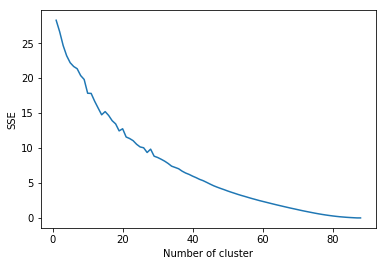

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
sse = {}
for k in range(1,delhi_grouped_clustering.shape[0]):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(delhi_grouped_clustering)
    delhi_grouped_clustering["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the above plot we can see the optimal number of clusters are **_25_**

Now let's get the data about Bangalore. We are using Wikipedia to get the neighbourhood names and places of Bangalore

In [40]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore')

Now, This time it returned 7 tables so let's process them all in order to get the right csv

In [41]:
t = tables[0]

In [42]:
csv_file = open('Banglore.csv', 'w')
csv_writer = csv.writer(csv_file)
#csv_writer.writerow(['District','Neighbourhood'])
for i in range(1,t.shape[0]):
    dist = 'Central'
    headq = t.iloc[i,0]
    csv_writer.writerow([dist,headq])
    
csv_file.close() 

Now we will append the above file with rest of the files so at last we are left with

In [43]:
t = tables[7]

csv_file = open('Banglore.csv', 'a')
csv_writer = csv.writer(csv_file)
#csv_writer.writerow(['District','Neighbourhood'])
for i in range(1,t.shape[0]):
    dist = 'Western'
    headq = t.iloc[i,0]
    csv_writer.writerow([dist,headq])
    
csv_file.close() 

So, let's import this into a dataframe

In [44]:
banglore = pd.read_csv('Banglore.csv')
banglore.head()

,Key,District,Neighbourhood
0,2,Central,Domlur
1,3,Central,Indiranagar
2,4,Central,Jeevanbheemanagar
3,5,Central,Malleswaram
4,7,Central,Rajajinagar


To get the coordinates of these we did the same procedure as we did with New Delhi

In [45]:
banglore_geo = pd.read_csv('Banglore_Geo.csv')
banglore_geo.head()

,Key,latitude,longitude
0,2,12.962467,77.638196
1,3,12.973291,77.640467
2,4,12.962900,77.659500
3,5,13.016341,77.558664
4,7,12.990100,77.552500


Let's merge them together

In [17]:
banglore_complete = banglore.merge(banglore_geo,on='Key',how='left')
banglore_complete.head()

,Key,District,Neighbourhood,latitude,longitude,Cluster Labels
0,2,Central,Domlur,12.962467,77.638196,3
1,3,Central,Indiranagar,12.973291,77.640467,3
2,4,Central,Jeevanbheemanagar,12.962900,77.659500,0
3,5,Central,Malleswaram,13.016341,77.558664,0
4,7,Central,Rajajinagar,12.990100,77.552500,0


Let us now visualize Bangalore 

In [18]:
latitude = 12.9716
longitude = 77.5946
# create map of New Delhi using latitude and longitude values
map_banglore = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat,long,neighbourhood in zip(banglore_complete['latitude'],banglore_complete['longitude'],banglore_complete['Neighbourhood']):
    label = f'{neighbourhood}'
    label = folium.Popup(label)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='yellow',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7).add_to(map_banglore)
    
map_banglore

Now, we will repeat the same procedure to get the details of Bangalore

In [50]:
banglore_venues = getNearbyVenues(names=banglore_complete['Neighbourhood'],
                                   latitudes=banglore_complete['latitude'],
                                   longitudes=banglore_complete['longitude']
                                  )

Domlur
Indiranagar
Jeevanbheemanagar
Malleswaram
Rajajinagar
Sadashivanagar
Seshadripuram
Shivajinagar
Ulsoor
Vasanth Nagar
Bellandur
CV Raman Nagar
Hoodi
Krishnarajapuram
Mahadevapura
Marathahalli
Varthur
Whitefield
Banaswadi
HBR Layout
Ramamurthy Nagar
Hebbal
Jalahalli
Mathikere
R. T. Nagar
Vidyaranyapura
Yelahanka
Yeshwanthpur
Bommanahalli
Bommasandra
BTM Layout
Electronic City
HSR Layout
Koramangala
Madiwala
Banashankari
Basavanagudi
Girinagar
J. P. Nagar
Jayanagar
Padmanabhanagar
Arekere
Begur
Gottigere
Basaveshwaranagar
Kamakshipalya
Kengeri
Nagarbhavi
Nandini Layout
Rajarajeshwari Nagar
Vijayanagar


In [51]:
print(f'Shape of banglore_venues = {banglore_venues.shape}')
banglore_venues.head()

Shape of banglore_venues = (552, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Domlur,12.962467,77.638196,Lavonne,12.963909,77.638579,Café
1,Domlur,12.962467,77.638196,Barbeque Nation,12.962684,77.641599,BBQ Joint
2,Domlur,12.962467,77.638196,Smoke House Deli,12.965584,77.641498,Deli / Bodega
3,Domlur,12.962467,77.638196,Drops Total Spirits,12.964527,77.641636,Liquor Store
4,Domlur,12.962467,77.638196,Mainland China,12.962458,77.641727,Chinese Restaurant


In [52]:
banglore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arekere,26,26,26,26,26,26
BTM Layout,36,36,36,36,36,36
Banashankari,7,7,7,7,7,7
Banaswadi,5,5,5,5,5,5
Basavanagudi,14,14,14,14,14,14
Basaveshwaranagar,19,19,19,19,19,19
Begur,5,5,5,5,5,5
Bellandur,24,24,24,24,24,24
Bommanahalli,6,6,6,6,6,6


In [53]:
# one hot encoding
banglore_onehot = pd.get_dummies(banglore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
banglore_onehot['Neighborhood'] = banglore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [banglore_onehot.columns[-1]] + list(banglore_onehot.columns[:-1])
banglore_onehot = banglore_onehot[fixed_columns]

banglore_onehot.head()

,Women's Store,ATM,Andhra Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,...,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Toll Plaza,Toy / Game Store,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
banglore_onehot.shape

(552, 122)

In [55]:
banglore_grouped = banglore_onehot.groupby('Neighborhood').mean().reset_index()
banglore_grouped

,Neighborhood,Women's Store,ATM,Andhra Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Toll Plaza,Toy / Game Store,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Arekere,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.038462,0.0,0.00,...,0.000000,0.038462,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000
1,BTM Layout,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.055556,0.000000
2,Banashankari,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000
3,Banaswadi,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.200000,0.000000
4,Basavanagudi,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000
5,Basaveshwaranagar,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000
6,Begur,0.00,0.2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000
7,Bellandur,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.041667,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000
8,Bommanahalli,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000
9,Bommasandra,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000


In [19]:
banglore_grouped.shape

(51, 122)

In [82]:
num_top_venues = 5

for hood in banglore_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = banglore_grouped[banglore_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arekere----
                 venue  freq
0    Indian Restaurant  0.19
1  Sporting Goods Shop  0.15
2          Pizza Place  0.08
3     Department Store  0.08
4                  Bar  0.04


----BTM Layout----
                           venue  freq
0              Indian Restaurant  0.22
1                 Ice Cream Shop  0.08
2                    Snack Place  0.08
3                         Bakery  0.06
4  Vegetarian / Vegan Restaurant  0.06


----Banashankari----
                     venue  freq
0        Indian Restaurant  0.29
1                     Café  0.29
2           Breakfast Spot  0.14
3  North Indian Restaurant  0.14
4              Pizza Place  0.14


----Banaswadi----
                           venue  freq
0              Indian Restaurant   0.2
1                         Bakery   0.2
2              Convenience Store   0.2
3                       Pharmacy   0.2
4  Vegetarian / Vegan Restaurant   0.2


----Basavanagudi----
               venue  freq
0  Indian Restaurant  0.29
1  

                           venue  freq
0                    Supermarket   1.0
1                  Women's Store   0.0
2                  Metro Station   0.0
3  Paper / Office Supplies Store   0.0
4                   Outlet Store   0.0


----Vasanth Nagar----
                venue  freq
0   Indian Restaurant  0.18
1         Coffee Shop  0.14
2  Chinese Restaurant  0.11
3  Italian Restaurant  0.07
4               Hotel  0.07


----Vidyaranyapura----
                           venue  freq
0                    Bus Station   1.0
1                  Women's Store   0.0
2             Mexican Restaurant   0.0
3                           Park   0.0
4  Paper / Office Supplies Store   0.0


----Vijayanagar----
                 venue  freq
0               Bakery   0.4
1    Indian Restaurant   0.2
2          Bus Station   0.2
3  Arts & Crafts Store   0.2
4          Music Venue   0.0


----Whitefield----
                         venue  freq
0                        Diner  0.11
1            Kerala Rest

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = banglore_grouped['Neighborhood']

for ind in np.arange(banglore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(banglore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arekere,Indian Restaurant,Sporting Goods Shop,Department Store,Pizza Place,Mughlai Restaurant,Chinese Restaurant,Liquor Store,Bus Line,Burger Joint,Bar
1,BTM Layout,Indian Restaurant,Ice Cream Shop,Snack Place,Chinese Restaurant,Sandwich Place,Pizza Place,Bakery,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Italian Restaurant
2,Banashankari,Café,Indian Restaurant,Breakfast Spot,Pizza Place,North Indian Restaurant,Halal Restaurant,Flea Market,Department Store,Dessert Shop,Hotel
3,Banaswadi,Convenience Store,Vegetarian / Vegan Restaurant,Indian Restaurant,Pharmacy,Bakery,Eastern European Restaurant,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Electronics Store
4,Basavanagudi,Indian Restaurant,Café,Restaurant,Convenience Store,Mediterranean Restaurant,Road,Metro Station,Hookah Bar,Diner,Dim Sum Restaurant
5,Basaveshwaranagar,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Sporting Goods Shop,Juice Bar,Food Truck,Pizza Place,Karnataka Restaurant,Snack Place,Bakery
6,Begur,ATM,Indian Restaurant,Indian Sweet Shop,Clothing Store,Food Court,Vietnamese Restaurant,Electronics Store,Flower Shop,Flea Market,Fish & Chips Shop
7,Bellandur,Indian Restaurant,Café,Fast Food Restaurant,Shopping Mall,Kerala Restaurant,Coffee Shop,Pizza Place,Lake,Burger Joint,Lounge
8,Bommanahalli,Indian Restaurant,Fast Food Restaurant,Department Store,South Indian Restaurant,Bakery,Vietnamese Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Eastern European Restaurant
9,Bommasandra,Indian Restaurant,Vietnamese Restaurant,Food Court,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store


Now to predict the values of Bangalore from New Delhi We need to make it into proper for that is Bangalore don't have some places which are present in New Delhi so let's add them with the value zero and make it predictable

In [25]:
banglore_grouped_clustering = banglore_grouped.drop('Neighborhood', 1)
banglore_grouped_clustering['Bookstore'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Hindu Temple'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Spa'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['American Restaurant'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Museum'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Tourist Information Center'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Hostel'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Golf Course'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Sculpture Garden'] = np.zeros(banglore_grouped_clustering.shape[0])
banglore_grouped_clustering['Trail'] = np.zeros(banglore_grouped_clustering.shape[0])

Let's predict Bangalore with the help of New Delhi in order to know which areas of New Delhi are simillar to which areas of Bangalore

In [27]:
banglore_predicted = kmeans.predict(banglore_grouped_clustering)

In [28]:
banglore_predicted

array([19,  4, 19,  4, 24, 19, 19, 19, 19, 15, 19,  4, 24, 19,  4, 19,  4,
       19,  4, 19,  4,  4,  4, 19, 19,  0, 19, 19, 19,  4, 22, 19, 19, 19,
        4, 19, 19, 19, 12, 19, 19,  4, 19, 19, 19,  4, 19, 19, 19,  4,  4])

In [29]:
banglore_merged = banglore_complete

# add clustering labels
banglore_merged['Cluster Labels'] = banglore_predicted

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
banglore_merged = banglore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

banglore_merged.head() # check the last columns!

,Key,District,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Central,Domlur,12.962467,77.638196,19,Indian Restaurant,Café,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,Food & Drink Shop,Liquor Store,Lounge,Deli / Bodega,Pizza Place
1,3,Central,Indiranagar,12.973291,77.640467,4,Pub,Café,Lounge,Dessert Shop,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Restaurant,Cocktail Bar,Cupcake Shop
2,4,Central,Jeevanbheemanagar,12.962900,77.659500,19,Fast Food Restaurant,Pizza Place,Bus Line,Vietnamese Restaurant,Food & Drink Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop
3,5,Central,Malleswaram,13.016341,77.558664,4,Department Store,Coffee Shop,Juice Bar,Bar,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant
4,7,Central,Rajajinagar,12.990100,77.552500,24,Bakery,Indian Restaurant,Snack Place,Paper / Office Supplies Store,Fast Food Restaurant,Café,Pharmacy,Dessert Shop,Dim Sum Restaurant,Diner


Let's visualize the clusters of Bangalore

In [32]:
latitude = 12.9716
longitude = 77.5946
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(len(banglore_predicted))]
colors_array = cm.seismic(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
color = ['black','orange','blue','red','purple','yellow','green']
def getcolor(cluster):
    if cluster == 19:
        return color[1]
    elif cluster == 4:
        return color[0]
    elif cluster == 24:
        return color[2]
    elif cluster == 15:
        return color[3]
    elif cluster == 0:
        return color[4]
    elif cluster == 22:
        return color[5]
    else :
        return color[6]
        

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(banglore_merged['latitude'], banglore_merged['longitude'], banglore_merged['Neighbourhood'], banglore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=getcolor(cluster),
        fill=True,
        fill_color=getcolor(cluster),
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters